# Pulse Benchmark - Evaluation
---
Calculates all metrics for task dataset combinations and prompt approaches from Metadata Files.
Creates heatmap for all combinations.

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import ast
import re

sys.path.append(r"C:\Users\janbe\Documents\GitHub Repos\pulse")
from src.eval.llm_analyzer import LLMAnalyzer, ModelAnalyzer
from src.eval.pulse_score import PULSEScoreCalculator

# Configuration and setup
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Set up directories
base_dir = r"C:\Users\janbe\Documents\GitHub Repos\pulse"
results_dir = os.path.join(base_dir, "output_to_keep", "results_benchmark")

#### Conventional Models

In [3]:
model_list = os.listdir(results_dir)
model_list

['20250603_160304_CNN',
 '20250603_192812_GRU',
 '20250604_094650_LSTM',
 '20250604_145501_XGBoost',
 '20250604_151243_LightGBM',
 '20250604_151406_RandomForest',
 '20250617_131406_InceptionTime',
 'llms',
 'results_output']

In [4]:
results_output_jsons = r"C:\Users\janbe\Documents\GitHub Repos\pulse\output_to_keep\results_benchmark\results_output\jsons"
result_dict = {}

In [6]:
for model in model_list:

    if model == "llms" or model == "results_output":
        continue

    print(f"Processing {model}...")

    cat_files = ModelAnalyzer.categorize_files(
        [os.path.join(results_dir, model)],
        verbose=False,
    )

    df_mdata = LLMAnalyzer.load_metadata(cat_files["metadata_files"])

    df_mdata = ModelAnalyzer.expand_full_dataset(df_mdata)

    # Strip "Model" from model_name and save as model_id

    df_mdata["model_id"] = (
        df_mdata["model_name"].str.replace("Model", "", regex=False).str.strip()
    )

    model_id = df_mdata["model_id"].unique()[0]
    result_dict[model_id] = {"score": None, "mdata": df_mdata}


# Calculate PULSE scores for each model


psc = PULSEScoreCalculator()


for model, data in result_dict.items():

    print(f"Calculating PULSE score for {model}...")

    df_mdata = data["mdata"]

    if df_mdata.empty:
        continue

    score = psc.calculate_pulse_score_from_dataframe(
        df=df_mdata,
        target_col="label_value",
        prob_col="probability",
        pred_col="binary_prediction",
        task_col="task",
        dataset_col="dataset",
    )
    score["prompting_id"] = ""  # empty for convModels
    score["model_id"] = model

    result_dict[model]["score"] = score

    # Save results as json. Uses pulse-result format
    json_output_path = os.path.join(results_output_jsons, f"{model}_results.json")
    LLMAnalyzer.save_results_dict_as_json({model: score}, json_output_path)

Processing 20250603_160304_CNN...
Extracting metadata from files:
Model Name: CNNModel, Task: aki, Dataset: eicu, Timestamp: 20250605_113136
Model Name: CNNModel, Task: aki, Dataset: hirid, Timestamp: 20250605_113136
Model Name: CNNModel, Task: aki, Dataset: miiv, Timestamp: 20250605_113136
Model Name: CNNModel, Task: mortality, Dataset: eicu, Timestamp: 20250603_160304
Model Name: CNNModel, Task: mortality, Dataset: hirid, Timestamp: 20250603_160304
Model Name: CNNModel, Task: mortality, Dataset: miiv, Timestamp: 20250603_160304
Model Name: CNNModel, Task: sepsis, Dataset: eicu, Timestamp: 20250605_113136
Model Name: CNNModel, Task: sepsis, Dataset: hirid, Timestamp: 20250605_113136
Model Name: CNNModel, Task: sepsis, Dataset: miiv, Timestamp: 20250605_113136

Processing 20250603_192812_GRU...
Extracting metadata from files:
Model Name: GRUModel, Task: aki, Dataset: eicu, Timestamp: 20250603_192812
Model Name: GRUModel, Task: aki, Dataset: hirid, Timestamp: 20250603_192812
Model Name:

#### LLMs

In [7]:
llm_model_list = os.listdir(os.path.join(results_dir, "llms"))
# llm_model_list = [llm_model_list[0], llm_model_list[2], llm_model_list[3], llm_model_list[-1]]
llm_model_list

['claudesonnet4',
 'deepseekr1llama8b',
 'gemini2p5flash',
 'gemini2p5pro',
 'gemma3',
 'gpt4o',
 'grok4',
 'llama3p18b',
 'medgemma',
 'mistral7b',
 'o3']

In [8]:
for llm_model in llm_model_list:
    print("===================================================")
    print(f"Processing LLM model: {llm_model}...")
    json_output_path = os.path.join(results_output_jsons, f"{llm_model}_results.json")
    result_dict[llm_model] = {}
    save_dict = {}
    prompt_approaches = os.listdir(os.path.join(results_dir, "llms", llm_model))
    for prompt_approach in prompt_approaches:
        print(f"Processing {prompt_approach}...")
        cat_files = LLMAnalyzer.categorize_files(
            [os.path.join(results_dir, "llms", llm_model, prompt_approach)],
            verbose=False,
        )
        df_mdata = LLMAnalyzer.load_metadata(cat_files["metadata_files"])
        if "Step Name" in df_mdata.columns:
            df_mdata = df_mdata[df_mdata["Step Name"] == "final_prediction"]
        ps = PULSEScoreCalculator()
        pulse_score = ps.calculate_pulse_score_from_raw_data(
            df=df_mdata,
            show_detailed_report=True,

        )
        result_dict[llm_model][prompt_approach] = {
                "score": pulse_score,
                "mdata": df_mdata,
        }

        pulse_score["model_id"] = llm_model
        pulse_score["prompting_id"] = prompt_approach
        save_dict[prompt_approach] = pulse_score
        print("--------------------------------------------")

    # Save results as json. Uses pulse-result format
    LLMAnalyzer.save_results_dict_as_json(
        save_dict, json_output_path
    )

Processing LLM model: claudesonnet4...
Processing hybrid_reasoning_agent_preprocessor...
Extracting metadata from files:
Model Name: ClaudeSonnet4, Task: aki, Dataset: eicu, Timestamp: 20250711_173050
Model Name: ClaudeSonnet4, Task: aki, Dataset: hirid, Timestamp: 20250711_173050
Model Name: ClaudeSonnet4, Task: aki, Dataset: miiv, Timestamp: 20250711_173050
Model Name: ClaudeSonnet4, Task: mortality, Dataset: eicu, Timestamp: 20250711_173050
Model Name: ClaudeSonnet4, Task: mortality, Dataset: hirid, Timestamp: 20250711_173050
Model Name: ClaudeSonnet4, Task: mortality, Dataset: miiv, Timestamp: 20250711_173050
Model Name: ClaudeSonnet4, Task: sepsis, Dataset: eicu, Timestamp: 20250711_173050
Model Name: ClaudeSonnet4, Task: sepsis, Dataset: hirid, Timestamp: 20250711_173050
Model Name: ClaudeSonnet4, Task: sepsis, Dataset: miiv, Timestamp: 20250711_173050

Preparing data for ClaudeSonnet4 PULSE score calculation...
Model Type: LLM
✓ No invalid predictions detected
✅ Data format is c

In [9]:
# Create the DataFrame
results_df = LLMAnalyzer.create_results_dataframe_from_pulse_results(result_dict)
results_df

,model_id,prompting_approach,task_dataset_key,pulse_score,base_score,auroc,auprc,mcc_raw,mcc,normalized_auprc,...,minpse,ccf,avg_penalty,total_penalties,num_penalized,dataset,task_id,model_name,run_id,task
0,CNN,,aki_eicu,70.804113,0.708041,0.779584,0.625295,0.437830,0.718915,2.017344,...,0.594771,1.000000,0.000000,0.00,0,eicu,aki,CNNModel,20250605_113136,NaN
1,CNN,,aki_hirid,63.257130,0.632571,0.807324,0.418029,0.342382,0.671191,2.581787,...,0.447853,1.000000,0.000000,0.00,0,hirid,aki,CNNModel,20250605_113136,NaN
2,CNN,,aki_miiv,68.607830,0.686078,0.774302,0.600746,0.366544,0.683272,2.581370,...,0.510549,1.000000,0.000000,0.00,0,miiv,aki,CNNModel,20250605_113136,NaN
3,CNN,,mortality_eicu,66.282400,0.662824,0.844854,0.452002,0.381538,0.690769,6.457172,...,0.428571,1.000000,0.000000,0.00,0,eicu,mortality,CNNModel,20250605_113136,NaN
4,CNN,,mortality_hirid,72.685949,0.726859,0.843718,0.608406,0.456815,0.728407,5.530964,...,0.545455,1.000000,0.000000,0.00,0,hirid,mortality,CNNModel,20250605_113136,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,o3,zhu_2024b_zero_shot_preprocessor,mortality_hirid,48.609313,0.490260,0.605209,0.289994,0.146137,0.573069,2.636305,...,0.333333,0.991500,0.008500,0.85,9,hirid,mortality,OpenAIo3,20250704_163021,mortality
614,o3,zhu_2024b_zero_shot_preprocessor,mortality_miiv,68.444150,0.686983,0.855587,0.467640,0.472462,0.736231,3.896998,...,0.583333,0.996300,0.003700,0.37,3,miiv,mortality,OpenAIo3,20250704_163021,mortality
615,o3,zhu_2024b_zero_shot_preprocessor,sepsis_eicu,38.994215,0.390600,0.572131,0.050936,0.088164,0.544082,1.062068,...,0.067616,0.998316,0.001684,1.65,26,eicu,sepsis,OpenAIo3,20250704_163021,sepsis
616,o3,zhu_2024b_zero_shot_preprocessor,sepsis_hirid,41.681063,0.417099,0.596051,0.192199,-0.076608,0.461696,2.551242,...,0.260274,0.999309,0.000691,0.67,11,hirid,sepsis,OpenAIo3,20250704_163021,sepsis


#### Plots

In [10]:
VARIABLE_NAMES = {
    "model_name": "Model Name",
    "task_id": "Task ID",
    "task": "Task",
    "dataset": "Dataset",
    "timestamp": "Timestamp",
    "model_id": "Model ID",
    "prompting_id": "Prompting ID",
    "sarvari_2024_aggregation_preprocessor": "Aggregation",
    "zhu_2024b_zero_shot_preprocessor": "Zero-shot",
    "liu_2023_few_shot_preprocessor": "Few-shot",
    "zhu_2024b_one_shot_preprocessor": "One-shot",
    "zhu_2024a_cot_preprocessor": "Chain-of-Thought",
    "zhu_2024c_categorization_summary_agent_preprocessor": "Categorization Summary Agent",
    "aki": "AKI",
    "mortality": "Mortality",
    "sepsis": "Sepsis",
    "eicu": "eICU",
    "miiv": "MIMIC-IV",
    "hirid": "HiRID",
    "deepseekr1llama8b": "DeepSeek-R1 (Llama-8B)",
    "gemini2p5flash": "Gemini 2.5 Flash",
    "gemini2p5pro": "Gemini 2.5 Pro",
    "gemma3": "Gemma 3 4B",
    "gpt4o": "GPT-4o",
    "llama3p18b": "Llama 3 8B",
    "medgemma": "MedGemma 4B",
    "mistral7b": "Mistral 7B",
    "claudesonnet4": "Claude Sonnet 4",
    "o3": "OpenAI o3",
    "hybrid_reasoning_agent_preprocessor": "Hybrid Reasoning Agent",
    "collaborative_reasoning_agent_preprocessor": "Collaborative Reasoning Agent",
    "clinical_workflow_agent_preprocessor": "Clinical Workflow Agent",
    "pulse_score": "PULSE",
    "auroc": "AUROC",
    "auprc": "AUPRC",
}

In [11]:
import seaborn as sns
def create_results_heatmap(df, score_column="pulse_score", figsize=(16, 10)):
    """
    Create a heatmap showing PULSE scores for task-dataset combinations vs model-prompting approach combinations,
    with aligned labels and horizontal separators for models.
    """
    # Make task-dataset combinations
    df_plot = df.copy()
    df_plot["task_dataset"] = (
        df_plot["task_id"].map(lambda x: VARIABLE_NAMES.get(x, x)).astype(str)
        + " - "
        + df_plot["dataset"].map(lambda x: VARIABLE_NAMES.get(x, x)).astype(str)
    )

    df_plot["model_clean"] = df_plot["model_id"].map(lambda x: VARIABLE_NAMES.get(x, x))
    df_plot["approach_clean"] = (
        df_plot["prompting_approach"]
        .fillna("")
        .map(lambda x: VARIABLE_NAMES.get(x, x) if x else "")
    )
    df_plot["model_approach"] = df_plot["model_clean"] + "|" + df_plot["approach_clean"]

    heatmap_range = {
        "vmin": 0,
        "vmax": 100,
    }  # Default range for pulse_score

    if score_column != "pulse_score":
        heatmap_range = {
            "vmin": 0,
            "vmax": 1,
        }

    # Pivot
    heatmap_data = df_plot.pivot_table(
        index="model_approach",
        columns="task_dataset",
        values=score_column,
        aggfunc="mean",
    )

    # Add Overall column (mean of all task-dataset combinations)
    heatmap_data["Overall"] = heatmap_data.mean(axis=1)

    # Sort heatmap_data by the Overall column in descending order
    heatmap_data = heatmap_data.sort_values(by="Overall", ascending=False)

    # Move Overall column to the end if not already
    cols = list(heatmap_data.columns)
    if "Overall" in cols:
        cols = [c for c in cols if c != "Overall"] + ["Overall"]
        heatmap_data = heatmap_data[cols]

    # Split model and approach for table
    labels_df = heatmap_data.index.to_frame(index=False)
    labels_df[["model", "approach"]] = labels_df["model_approach"].str.split(
        "|", expand=True
    )
    labels_df = labels_df.fillna("")

    matrix = heatmap_data.copy()

    # Make figure: give table more width
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(
        1, 2, width_ratios=[2.5, 4], wspace=-0.1
    )  # More room for table

    # Table axis (left)
    ax_table = fig.add_subplot(gs[0])
    ax_table.axis("off")

    # Heatmap axis (right)
    ax_heatmap = fig.add_subplot(gs[1])

    # Plot heatmap without y-ticks
    sns.heatmap(
        matrix,
        annot=True,
        fmt=".2f",  # Change to ".2f" for two decimal places, ".1f" for one, etc.
        cmap="RdYlBu_r",
        vmin=heatmap_range["vmin"],
        vmax=heatmap_range["vmax"],
        cbar_kws={"label": f"{VARIABLE_NAMES.get(score_column,score_column)} Score"},
        linewidths=0.5,
        linecolor="gray",
        ax=ax_heatmap,
    )

    ax_heatmap.set_yticks([])
    ax_heatmap.set_ylabel("")
    ax_heatmap.set_xlabel("Task - Dataset", fontsize=14, fontweight="bold")
    ax_heatmap.set_xticklabels(
        ax_heatmap.get_xticklabels(), rotation=45, ha="right", fontsize=12
    )

    # Adjust table text positions: more horizontal spacing
    x_model = 0.0
    x_approach = 2.7  # More space to prevent overlap
    num_rows = matrix.shape[0]

    ax_table.text(x_model, num_rows + 2, "Model", fontsize=14, ha="left")
    ax_table.text(
        x_approach,
        num_rows + 2,
        "Approach",
        fontsize=14,
        ha="left",
    )

    # Add custom labels and long horizontal lines
    last_model = None
    for i, (model, approach) in enumerate(
        zip(labels_df["model"], labels_df["approach"])
    ):
        y = i + 0.5  # Changed from: num_rows - i - 0.5

        ax_table.text(
            x_model,
            y,
            model,
            va="center",
            ha="left",
            fontsize=9,
        )
        ax_table.text(x_approach, y, approach, va="center", ha="left", fontsize=9)

        if i > 0: #and model != last_model and model != "Overall":
            # Draw hline in BOTH axes so it spans full width
            ax_table.hlines(
                y - 0.5, x_model, x_approach + 5, color="grey", linewidth=0.5
            )  # Changed from: y + 0.5
            ax_heatmap.hlines(
                y - 0.5, *ax_heatmap.get_xlim(), color="grey", linewidth=0.5
            )  # Changed from: y + 0.5

        last_model = model

    # Match y-limits
    ax_table.set_ylim(ax_heatmap.get_ylim())

    fig.suptitle(
        f"{VARIABLE_NAMES.get(score_column,score_column)} Scores: Task-Dataset Combinations vs Model-Prompting Approaches",
        fontsize=18,
        fontweight="bold",
        y=1.02,
    )

    plt.tight_layout()
    plt.show()

    return matrix

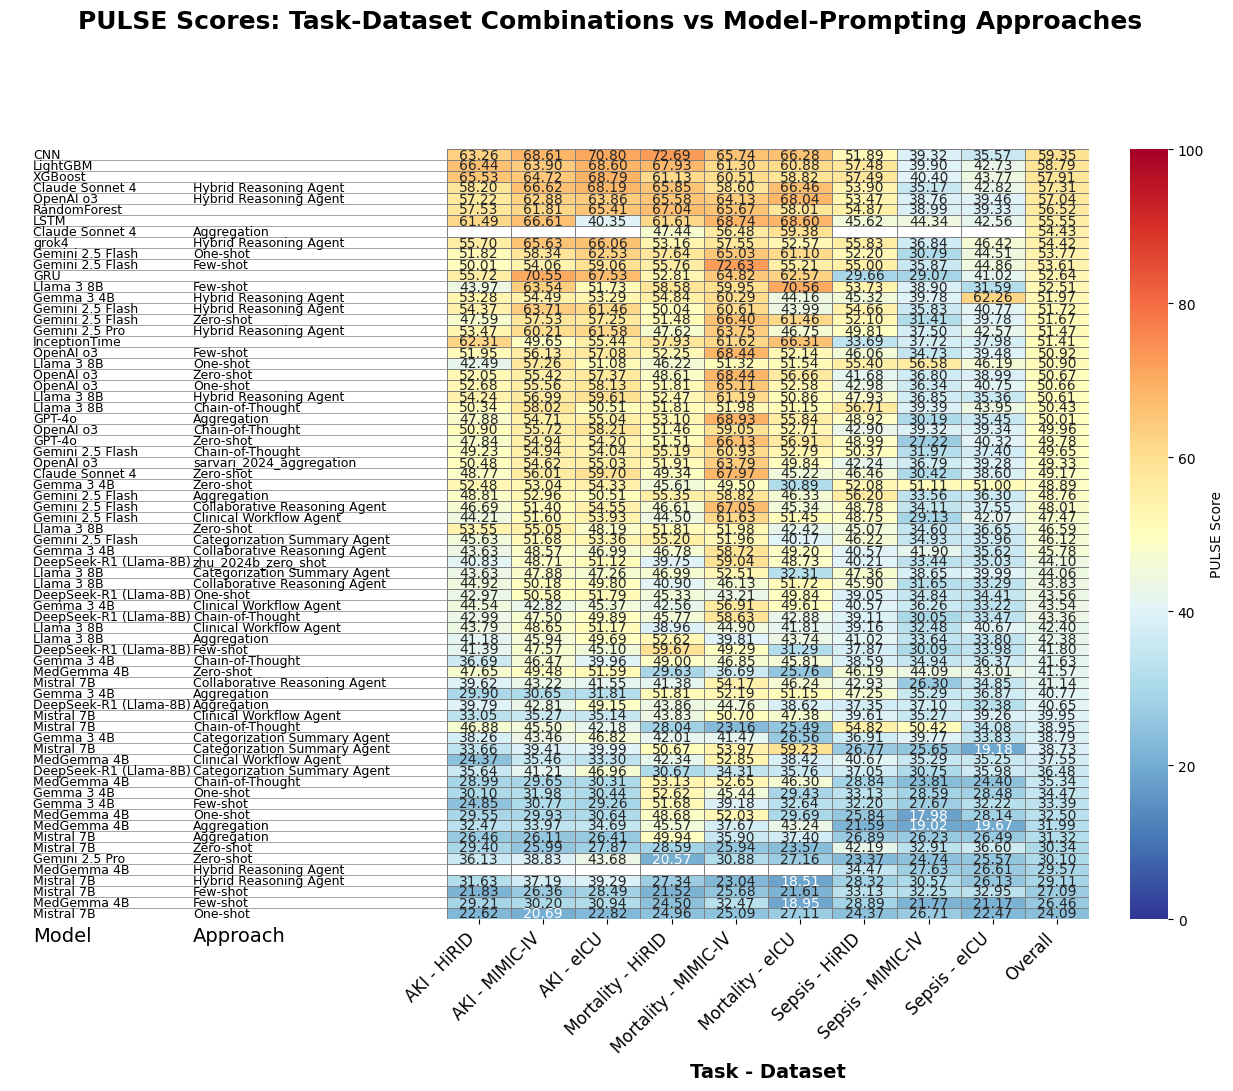

task_dataset,AKI - HiRID,AKI - MIMIC-IV,AKI - eICU,Mortality - HiRID,Mortality - MIMIC-IV,Mortality - eICU,Sepsis - HiRID,Sepsis - MIMIC-IV,Sepsis - eICU,Overall
model_approach,,,,,,,,,,
CNN|,63.257130,68.607830,70.804113,72.685949,65.741794,66.282400,51.890051,39.315536,35.567144,59.350216
LightGBM|,66.441234,63.895265,68.596767,67.927637,61.298748,60.881373,57.479672,39.895458,42.729290,58.793938
XGBoost|,65.525720,64.722185,68.787675,61.130435,60.507722,58.821800,57.485541,40.401319,43.768505,57.905656
Claude Sonnet 4|Hybrid Reasoning Agent,58.195297,66.617618,68.186777,65.853515,58.599301,66.463247,53.898219,35.172455,42.824553,57.312331
OpenAI o3|Hybrid Reasoning Agent,57.222645,62.876948,63.858286,65.579572,64.128345,68.040789,53.470397,38.757892,39.457301,57.043575
...,...,...,...,...,...,...,...,...,...,...
MedGemma 4B|Hybrid Reasoning Agent,NaN,NaN,NaN,NaN,NaN,NaN,34.467363,27.631464,26.611098,29.569975
Mistral 7B|Hybrid Reasoning Agent,31.629110,37.194374,39.285115,27.335708,23.038964,18.513462,28.317843,30.571323,26.133256,29.113240
Mistral 7B|Few-shot,21.828946,26.355356,28.492257,21.520259,25.676121,21.612984,33.125609,32.249533,32.948787,27.089984


In [12]:
create_results_heatmap(results_df)

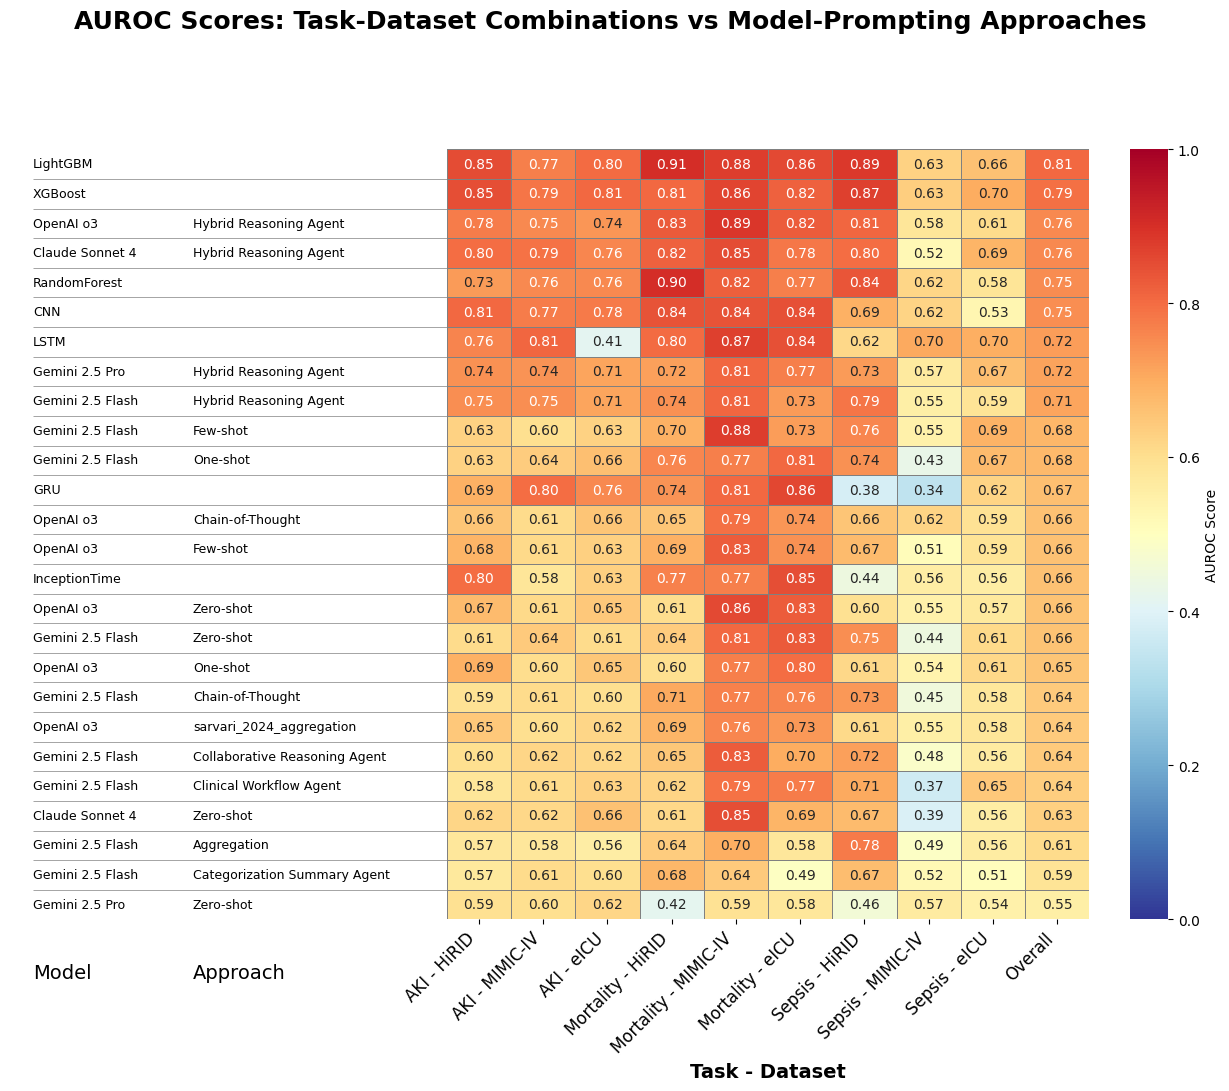

task_dataset,AKI - HiRID,AKI - MIMIC-IV,AKI - eICU,Mortality - HiRID,Mortality - MIMIC-IV,Mortality - eICU,Sepsis - HiRID,Sepsis - MIMIC-IV,Sepsis - eICU,Overall
model_approach,,,,,,,,,,
LightGBM|,0.853151,0.772423,0.802476,0.906027,0.878788,0.857143,0.886519,0.626556,0.662724,0.805090
XGBoost|,0.849695,0.785868,0.805378,0.805924,0.864583,0.817204,0.872000,0.634970,0.702836,0.793162
OpenAI o3|Hybrid Reasoning Agent,0.775641,0.754085,0.737751,0.831461,0.889205,0.824885,0.812240,0.580249,0.609003,0.757169
Claude Sonnet 4|Hybrid Reasoning Agent,0.798578,0.791142,0.761455,0.819203,0.851799,0.781874,0.799207,0.522611,0.685982,0.756872
RandomForest|,0.728642,0.755206,0.757176,0.902451,0.822917,0.773425,0.838716,0.619986,0.582613,0.753459
CNN|,0.807324,0.774302,0.779584,0.843718,0.841856,0.844854,0.693753,0.623544,0.528631,0.748619
LSTM|,0.762451,0.808734,0.410353,0.803882,0.871212,0.844854,0.615399,0.704829,0.698388,0.724456
Gemini 2.5 Pro|Hybrid Reasoning Agent,0.743823,0.740692,0.714532,0.719101,0.810133,0.771121,0.730331,0.569948,0.665385,0.718341
Gemini 2.5 Flash|Hybrid Reasoning Agent,0.747476,0.748622,0.712497,0.744127,0.809659,0.729647,0.788145,0.551358,0.587268,0.713200


In [12]:
create_results_heatmap(results_df, score_column="auroc", figsize=(16, 10))

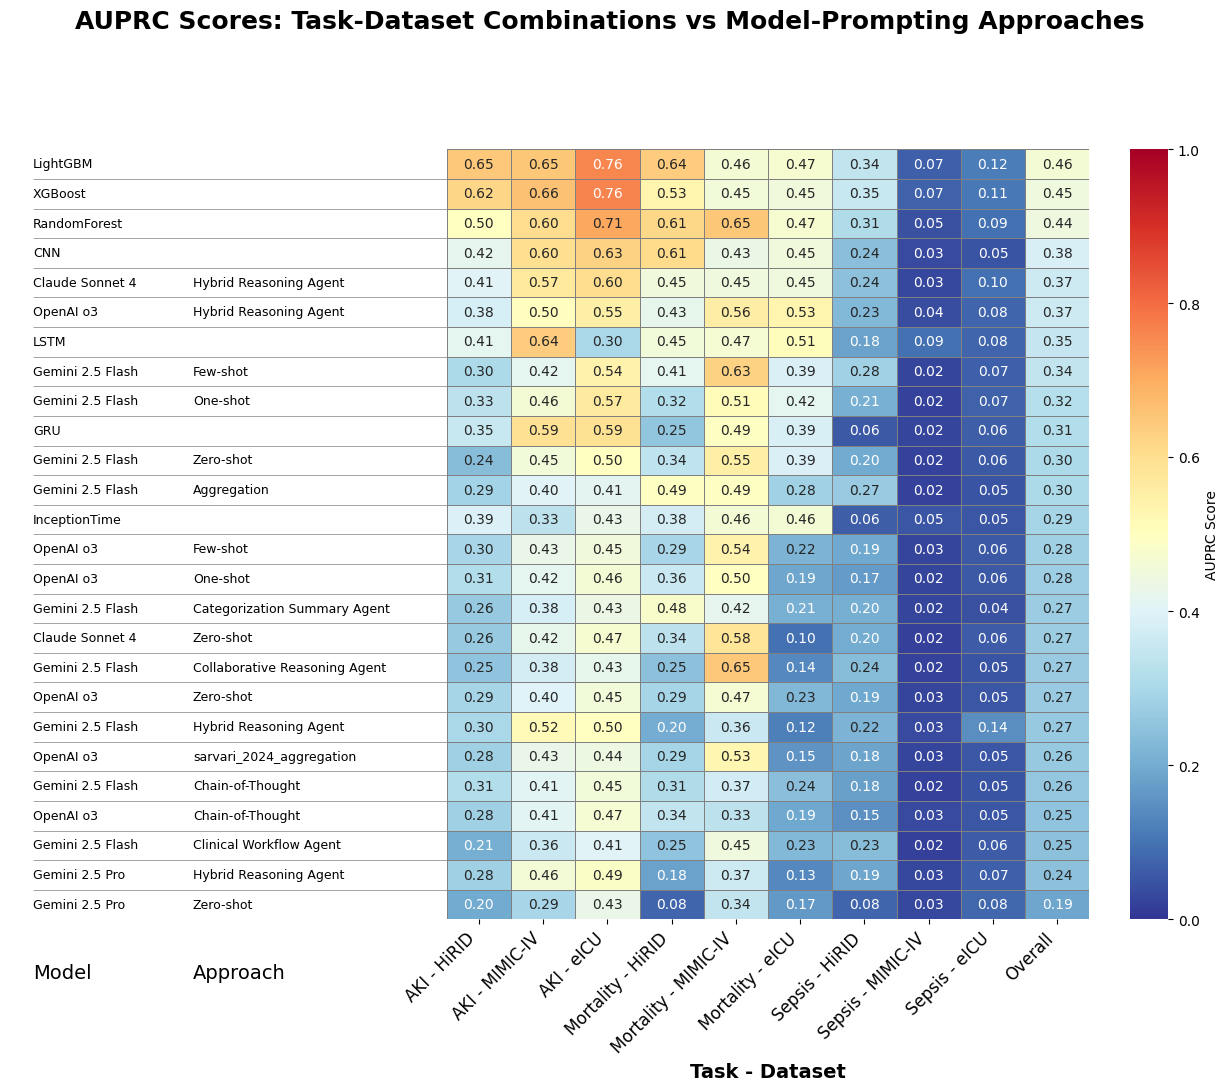

task_dataset,AKI - HiRID,AKI - MIMIC-IV,AKI - eICU,Mortality - HiRID,Mortality - MIMIC-IV,Mortality - eICU,Sepsis - HiRID,Sepsis - MIMIC-IV,Sepsis - eICU,Overall
model_approach,,,,,,,,,,
LightGBM|,0.645068,0.648646,0.761062,0.637235,0.463598,0.472596,0.340138,0.067246,0.116952,0.461393
XGBoost|,0.620782,0.660258,0.763945,0.531362,0.453832,0.450123,0.354835,0.074161,0.108331,0.446403
RandomForest|,0.499625,0.602774,0.709646,0.613770,0.652057,0.469318,0.308977,0.046466,0.093950,0.444065
CNN|,0.418029,0.600746,0.625295,0.608406,0.430047,0.452002,0.239902,0.034525,0.050698,0.384406
Claude Sonnet 4|Hybrid Reasoning Agent,0.406194,0.573717,0.601629,0.450918,0.448660,0.448769,0.244959,0.028069,0.096580,0.366611
OpenAI o3|Hybrid Reasoning Agent,0.382047,0.500521,0.551339,0.425559,0.558046,0.533089,0.230103,0.038201,0.077283,0.366243
LSTM|,0.414600,0.638535,0.297206,0.453665,0.465228,0.506903,0.182619,0.094697,0.076133,0.347732
Gemini 2.5 Flash|Few-shot,0.301763,0.417566,0.541327,0.414740,0.627842,0.388841,0.281911,0.024961,0.067423,0.340708
Gemini 2.5 Flash|One-shot,0.333913,0.460958,0.569672,0.316011,0.509840,0.415287,0.209643,0.019624,0.072422,0.323041


In [13]:
create_results_heatmap(results_df, score_column="auprc", figsize=(16, 10))